# Classification: Data Modeling

In [26]:
import pickle

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from os.path import exists

from scipy.stats import uniform
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

pd.set_option('display.max_colwidth', 100)

In [27]:
target = 'tweets'

# The first line for upsampled data, the second for the original data
supervised_up_target_path = f'../dataset/processed/supervised_{target}_upsampled.csv'
supervised_down_target_path = f'../dataset/processed/supervised_{target}_downsampled.csv'
supervised_target_path = f'../dataset/processed/supervised_{target}.csv'

model_path = '../dataset/model/sental_model.pkl'
model_best_params_path = '../dataset/model/svm_best_params.pkl'
vectorizer_path = '../dataset/model/sental_vectorizer.pkl'

In [28]:
# df = pd.read_csv(supervised_target_path, delimiter=';')
df = pd.read_csv(supervised_up_target_path, delimiter=';')
# df = pd.read_csv(supervised_down_target_path, delimiter=';')

df

,level_0,index,date,content,text_clean,case_folding,tokens,review,polarity,sentiment,label
0,0,0,2022-09-04 23:59:55+00:00,@soeyoto1 @msaid_didu Bukti kalau Pemerintahan Pak @jokowi tidak pro rakyat. Tapi pro oligarki. ...,Bukti kalau Pemerintahan Pak tidak pro rakyat Tapi pro oligarki Vivo BBMnya lebih murah dari Pem...,bukti kalau pemerintahan pak tidak pro rakyat tapi pro oligarki vivo bbmnya lebih murah dari pem...,"['bukti', 'kalau', 'perintah', 'tidak', 'pro', 'rakyat', 'pro', 'oligarki', 'vivo', 'bmnya', 'le...",bukti kalau perintah tidak pro rakyat pro oligarki vivo bmnya lebih murah dari perintah naikin a...,-12,0,Negative
1,1,1,2022-09-04 23:59:38+00:00,"@KompasTV Mentri esdm, trus patokanmu apa? Kantong pertamina udah jebol karna banyak dikorupsi, ...",Mentri esdm trus patokanmu apa Kantong pertamina udah jebol karna banyak dikorupsi imbasnya raky...,mentri esdm trus patokanmu apa kantong pertamina udah jebol karna banyak dikorupsi imbasnya raky...,"['tri', 'esdm', 'trus', 'patok', 'apa', 'kantong', 'pertamina', 'udah', 'jebol', 'karna', 'banya...",tri esdm trus patok apa kantong pertamina udah jebol karna banyak korupsi imbas rakyat yang mena...,-18,0,Negative
2,2,2,2022-09-04 23:59:09+00:00,@hnurwahid Ngaku masih subsidi tapi ada swasta yg jua lebih murah? mereka siapa yg subsidi? Pert...,Ngaku masih subsidi tapi ada swasta jua lebih murah mereka siapa subsidi Pertamina dipimpin tuka...,ngaku masih subsidi tapi ada swasta jua lebih murah mereka siapa subsidi pertamina dipimpin tuka...,"['ngaku', 'subsidi', 'ada', 'swasta', 'jua', 'lebih', 'murah', 'siapa', 'subsidi', 'pertamina', ...",ngaku subsidi ada swasta jua lebih murah siapa subsidi pertamina pimpin tukang maki jadi begini ...,-4,0,Negative
3,3,3,2022-09-04 23:58:55+00:00,@Tan_Mar3M Kalau Vivo bisaberani bertahan dengan harga lama bagaimana pula nasib Pertamina ? 🤔,Kalau Vivo bisaberani bertahan dengan harga lama bagaimana pula nasib Pertamina,kalau vivo bisaberani bertahan dengan harga lama bagaimana pula nasib pertamina,"['kalau', 'vivo', 'bisaberani', 'tahan', 'harga', 'lama', 'nasib', 'pertamina']",kalau vivo bisaberani tahan harga lama nasib pertamina,-3,0,Negative
4,4,4,2022-09-04 23:57:45+00:00,Menteri BUMN Erick Thohir menegaskan persiapan Indonesia soal transisi energi baru terbarukan. S...,Menteri BUMNErick Thohirmenegaskan persiapan Indonesia soal transisi energi baru terbarukan Sala...,menteri bumnerick thohirmenegaskan persiapan indonesia soal transisi energi baru terbarukan sala...,"['menteri', 'bumnerick', 'thohirmenegaskan', 'siap', 'indonesia', 'soal', 'transisi', 'energi', ...",menteri bumnerick thohirmenegaskan siap indonesia soal transisi energi salah satu upaya lewat ke...,-5,0,Negative
...,...,...,...,...,...,...,...,...,...,...,...
8275,5573,5843,2022-09-03 10:11:33+00:00,PIEDDC kunci Pertamina dalam menjaga ketersediaan stok BBM subsidi. https://t.co/zwQM2my20N,PIEDDC kunci Pertamina dalam menjaga ketersediaan stok BBM subsidi,pieddc kunci pertamina dalam menjaga ketersediaan stok bbm subsidi,"['piedc', 'kunci', 'pertamina', 'dalam', 'jaga', 'dian', 'stok', 'bm', 'subsidi']",piedc kunci pertamina dalam jaga dian stok bm subsidi,2,1,Positive
8276,2913,3033,2022-09-04 04:00:26+00:00,Mau punya pertamina.,Mau punya pertamina,mau punya pertamina,"['mau', 'punya', 'pertamina']",mau punya pertamina,7,1,Positive
8277,6055,6368,2022-09-03 08:00:54+00:00,"@asumsico Pas baca tread asumsi kalo pertamax naik,langsung buru buru ke pertamina buat isi, thx...",Pas baca tread asumsi kalo pertamax naiklangsung buru buru pertamina buat isi thx min irit ribu ...,pas baca tread asumsi kalo pertamax naiklangsung buru buru pertamina buat isi thx min irit ribu ...,"['pas', 'baca', 'tread', 'asumsi', 'kalo', 'pertamax', 'naiklangsung', 'buru', 'buru', 'pertamin...",pas baca tread asumsi kalo pertamax naiklangsung buru buru pertamina buat isi thx min irit ribu ...,0,1,Positive
8278,3873,4030,2022-09-03 18:27:01+00:00,"@RadioElshinta Belum, aturannya harga BBM 

## Section 1: Term weighting with TF-IDF & Data Splitting

In [29]:
def term_weighting_tfidf(X_train, X_test):
	vectorizer = TfidfVectorizer(use_idf=True, min_df = 5, max_df = 0.8, sublinear_tf = True)

	X_train_tfidf = vectorizer.fit_transform(X_train)
	X_test_tfidf = vectorizer.transform(X_test)
	return X_train_tfidf, X_test_tfidf, vectorizer

def save_vectorizer(model_vectorizer):
  with open(vectorizer_path, 'wb') as f:
    pickle.dump(model_vectorizer, f)

In [30]:
def split_data(test_size=0.2):
		X = df['review']
		y = df['sentiment']
		return train_test_split(X, y, test_size=test_size, random_state=687)

def split_stratified_data(test_size=0.2):
		X = df['review']
		y = df['sentiment']
		return train_test_split(X, y, test_size=test_size, random_state=687, stratify=y)

## Section 2: Classification with SVM

In [31]:
def save_svm_best_param(best_params):
  with open(model_best_params_path, 'wb') as f:
    pickle.dump(best_params, f)

def save_model(model):
  with open(model_path, 'wb') as f:
    pickle.dump(model, f)

def random_best_search_param(X_train_tfidf, y_train):
  param_grid = {'C': uniform(loc=0, scale=4),
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma': uniform(loc=0, scale=0.1)}
  model = svm.SVC()
  grid_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=100, cv=5, n_jobs=-1, random_state=0, verbose=1, scoring='accuracy', return_train_score=True, error_score=0.0, refit=True, pre_dispatch='2*n_jobs')
  grid_search.fit(X_train_tfidf, y_train)

  save_svm_best_param(grid_search.best_params_)

  print("Best parameters: ", grid_search.best_params_)
  print("Best score: ", grid_search.best_score_)
  
  return grid_search.best_params_

def load_svm_best_param():
	try:
		with open(model_best_params_path, 'rb') as f:
			return pickle.load(f)
	except FileNotFoundError:
		return None

def load_svm_model(X_train_tfidf, y_train):
    model = None

    if exists(model_path):
      with open(model_path, 'rb') as f:
        model = pickle.load(f)
    else:
      best_params = load_svm_best_param()
      if best_params is None:
        best_params = random_best_search_param(X_train_tfidf, y_train)
        print("Loaded best parameters from grid search")
      else:
        print("Use parameters: ", best_params)
        print("Loaded best parameters from file")
      
      # add probability=True to get probabilities
      model = svm.SVC(**best_params, decision_function_shape='ovr', probability=True)

    print('Parameters: ', model.get_params())
    return model

def model_predict(model, y, y_pred):
	acc = accuracy_score(y, y_pred)
	precision = precision_score(y, y_pred, average='binary')
	recall = recall_score(y, y_pred, average='binary')
	f1 = f1_score(y, y_pred, average='binary')
	matrix = confusion_matrix(y, y_pred)

	print("Accuracy:", acc)
	print("Precision:", precision)
	print("Recall:", recall)
	print("F1-Score:", f1)
	print('Confusion Matrix :')
	print(matrix)
	print('\n Report : ') 
	print(classification_report(y, y_pred))

	f, ax = plt.subplots(figsize=(8,5))
	sns.heatmap(matrix, annot=True, fmt=".0f", ax=ax)
	plt.xlabel("Predicted")
	plt.ylabel("Actual")
	plt.show()

## Section 3: Experiments

### Section 3.1: SVM with TF-IDF (Non-Stratified Data)

In [32]:
X_train, X_test, y_train, y_test = split_data()
X_train_tfidf, X_test_tfidf, vectorizer = term_weighting_tfidf(X_train, X_test)

print('Train data count: ', len(X_train))
print('Train data positive count: ', len(y_train[y_train == 1]))
print('Train data negative count: ', len(y_train[y_train == 0]))
print('Test data count: ', len(X_test))
print('Test data positive count: ', len(y_test[y_test == 1]))
print('Test data negative count: ', len(y_test[y_test == 0]))
print()
print(df.shape)

svm_model = load_svm_model(X_train_tfidf, y_train)
svm_model.fit(X_train_tfidf, y_train)

model_score = svm_model.score(X_test_tfidf, y_test)
print("Model score: ", model_score)

Train data count:  6624
Train data positive count:  3312
Train data negative count:  3312
Test data count:  1656
Test data positive count:  828
Test data negative count:  828

(8280, 11)
Parameters:  {'C': 2.491384382186678, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.06736596308357894, 'kernel': 'linear', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Model score:  0.8997584541062802


#### Section 3.1.1: Evaluation

Accuracy: 0.8997584541062802
Precision: 0.8787185354691075
Recall: 0.927536231884058
F1-Score: 0.9024676850763806
Confusion Matrix :
[[722 106]
 [ 60 768]]

 Report : 
              precision    recall  f1-score   support

           0       0.92      0.87      0.90       828
           1       0.88      0.93      0.90       828

    accuracy                           0.90      1656
   macro avg       0.90      0.90      0.90      1656
weighted avg       0.90      0.90      0.90      1656



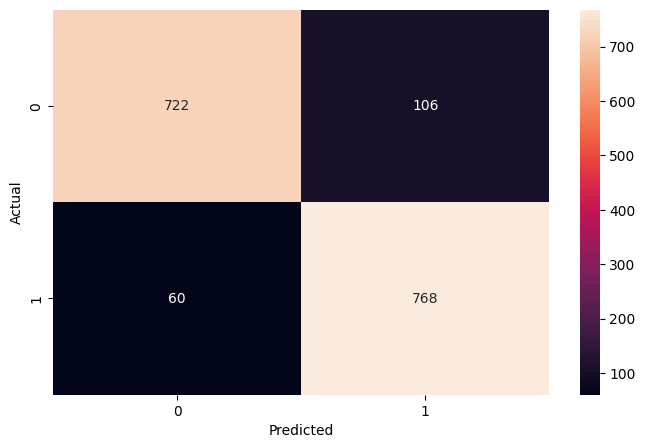

Accuracy: 0.9731280193236715
Precision: 0.9627879503839338
Recall: 0.9842995169082126
F1-Score: 0.9734249029561063
Confusion Matrix :
[[3186  126]
 [  52 3260]]

 Report : 
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      3312
           1       0.96      0.98      0.97      3312

    accuracy                           0.97      6624
   macro avg       0.97      0.97      0.97      6624
weighted avg       0.97      0.97      0.97      6624



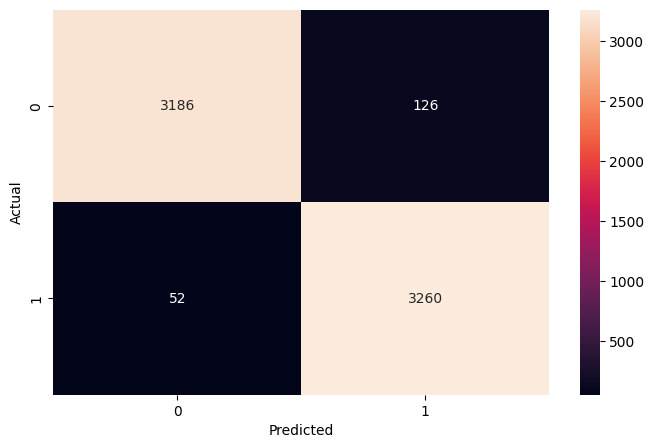

In [33]:
y_pred_train = svm_model.predict(X_train_tfidf)
y_pred_test = svm_model.predict(X_test_tfidf)

model_predict(svm_model, y_test, y_pred_test)
model_predict(svm_model, y_train, y_pred_train)

### Section 3.2: SVM with TF-IDF (Stratified Data)

In [34]:
X_train, X_test, y_train, y_test = split_stratified_data()
X_train_tfidf, X_test_tfidf, vectorizer = term_weighting_tfidf(X_train, X_test)

print('Train data count: ', len(X_train))
print('Train data positive count: ', len(y_train[y_train == 1]))
print('Train data negative count: ', len(y_train[y_train == 0]))
print('Test data count: ', len(X_test))
print('Test data positive count: ', len(y_test[y_test == 1]))
print('Test data negative count: ', len(y_test[y_test == 0]))
print()
print(df.shape)

svm_model = load_svm_model(X_train_tfidf, y_train)
svm_model.fit(X_train_tfidf, y_train)

model_score = svm_model.score(X_test_tfidf, y_test)
print("Model score: ", model_score)

Train data count:  6624
Train data positive count:  3312
Train data negative count:  3312
Test data count:  1656
Test data positive count:  828
Test data negative count:  828

(8280, 11)
Parameters:  {'C': 2.491384382186678, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.06736596308357894, 'kernel': 'linear', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Model score:  0.9112318840579711


#### Section 3.2.1: Evaluation

Accuracy: 0.9112318840579711
Precision: 0.872946330777656
Recall: 0.9625603864734299
F1-Score: 0.9155657668006891
Confusion Matrix :
[[712 116]
 [ 31 797]]

 Report : 
              precision    recall  f1-score   support

           0       0.96      0.86      0.91       828
           1       0.87      0.96      0.92       828

    accuracy                           0.91      1656
   macro avg       0.92      0.91      0.91      1656
weighted avg       0.92      0.91      0.91      1656



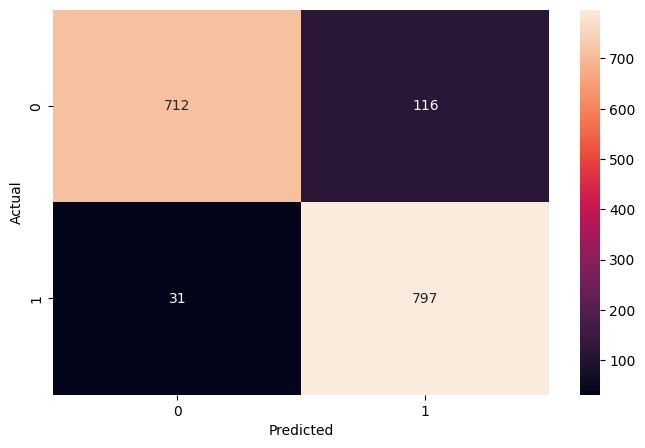

Accuracy: 0.9707125603864735
Precision: 0.958259847148736
Recall: 0.9842995169082126
F1-Score: 0.9711051534107834
Confusion Matrix :
[[3170  142]
 [  52 3260]]

 Report : 
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      3312
           1       0.96      0.98      0.97      3312

    accuracy                           0.97      6624
   macro avg       0.97      0.97      0.97      6624
weighted avg       0.97      0.97      0.97      6624



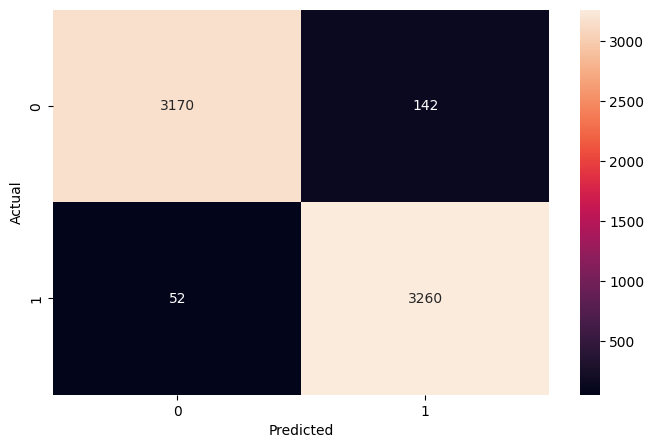

In [35]:
y_pred_train = svm_model.predict(X_train_tfidf)
y_pred_test = svm_model.predict(X_test_tfidf)

model_predict(svm_model, y_test, y_pred_test)
model_predict(svm_model, y_train, y_pred_train)

## Section 4: Test & Conclusion

In [36]:
%run "../shared.py"

In [37]:
# Results from prediction sentiment on data test

result_test = pd.DataFrame(data=zip(X_test, y_pred_test), columns=['review', 'code'])

polarity_decode = {0 : 'Negative', 1 : 'Positive'}
result_test['sentiment'] = result_test['code'].map(polarity_decode)

pd.set_option('max_colwidth', 300)
result_test.sample(10)

,review,code,sentiment
1385,andai semarang ada pilih spbu pertamina,1,Positive
660,sebenernya knp harus ikut harga minyak dunia turut bang dicta praktik indo memang ikut harga mi dunia pertamina murni operator apa kurang subsidi pengaruh untung pertamina mumet salah bang dicta jago mtk,0,Negative
1346,jadi ada yang nama harga dasar bm itu udah tetap sama perintah jadi tujuanya biar pertamina gak kalah saing soal aja shel dk banting harga bakar duit buat nyari konsumen,0,Negative
511,vivo itu swasta yang subsidi siapa klu gak subsidi pertaminapemerintah ungud ato yang pintar coba tanya,0,Negative
1479,demo pertamina malming gaji,0,Negative
156,musti tegur ditjen energi takut amat saing pertamina,1,Positive
609,malaysia ron liter indonesia ron liter petronas untung pertamina rugi itu guru matematika sapa yah barbuk pertalite pertamax solar,0,Negative
1301,pertamina itu punya siapa blog,0,Negative
1109,yup sama kek kemarenan shel hrg sama sama pertamina dadak mingu hrg naik lgs rebu sampe rebu gegara org semua lari shelitu sama gak lebih murah,1,Positive
738,pertamax turbo pertamina dex sama dexlite kalo gak salahbuat orang kaya diturunin buat orang miskin dinaikinlucu emang,0,Negative


In [38]:
sample_text = 'Kami Mendukung Keputusan PemeRintah untUk menAIkkan HARga BBM'
sample_text = preprocess_text(sample_text)

sample_text_tfidf = vectorizer.transform([sample_text])
polarity = svm_model.predict(sample_text_tfidf)

sentiment = polarity_decode[polarity[0]]

print(f"Sampel text: {sample_text}")
print(f"Sentiment: {sentiment}")

Normalization list: 1043
Indonesian stopwords: 540
English stopwords: 179
Custom stopwords: 17
Total stopwords: 736
Sampel text: dukung putus perintah naik harga bbm
Sentiment: Positive


In [39]:
sample_text = 'saya benci pemerintah'
sample_text = preprocess_text(sample_text)

sample_text_tfidf = vectorizer.transform([sample_text])
polarity = svm_model.predict(sample_text_tfidf)
# polarity_proba = svm_model.predict_proba(sample_text_tfidf)

sentiment = polarity_decode[polarity[0]]

print(f"Sampel text: {sample_text}")
print(f"Sentiment: {sentiment}")

Normalization list: 1043
Indonesian stopwords: 540
English stopwords: 179
Custom stopwords: 17
Total stopwords: 736
Sampel text: saya benci perintah
Sentiment: Negative


In [40]:
save_model(svm_model)
save_vectorizer(vectorizer)

## Section 5: Visualizations

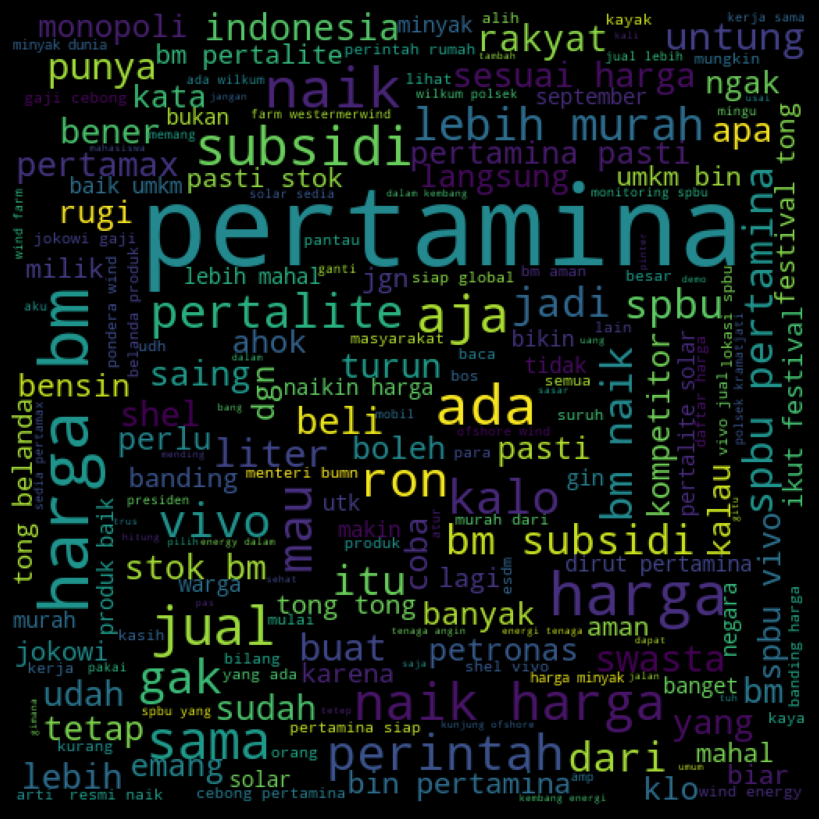

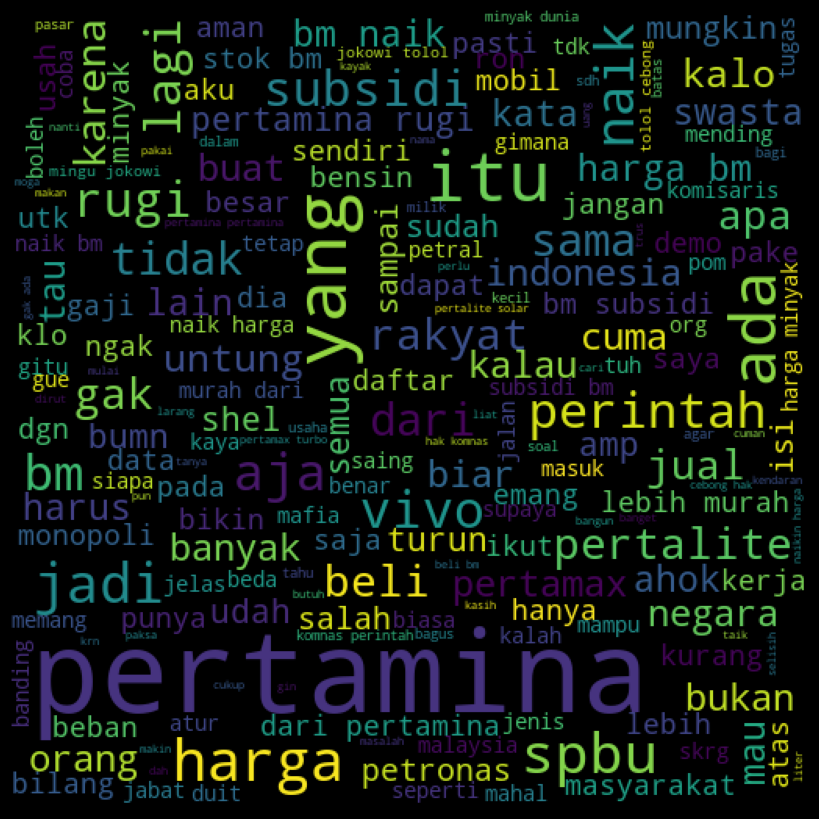

In [41]:
#word cloud for positive review words
pos_words = ' '.join(list(result_test[result_test['code'] == 1]['review']))
pos_wordcloud = WordCloud(width=512,height=512).generate(pos_words)
plt.figure(figsize=(10,8),facecolor = 'k')
plt.imshow(pos_wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

#word cloud for negative review words
neg_words = ' '.join(list(result_test[result_test['code'] == 0]['review']))
neg_wordcloud = WordCloud(width=512,height=512).generate(neg_words)
plt.figure(figsize=(10,8),facecolor = 'k')
plt.imshow(neg_wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

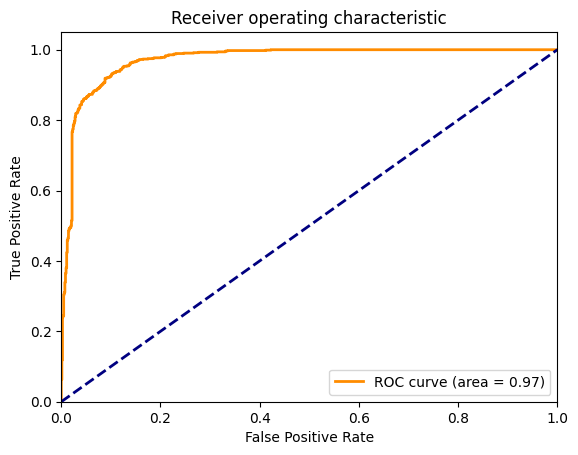

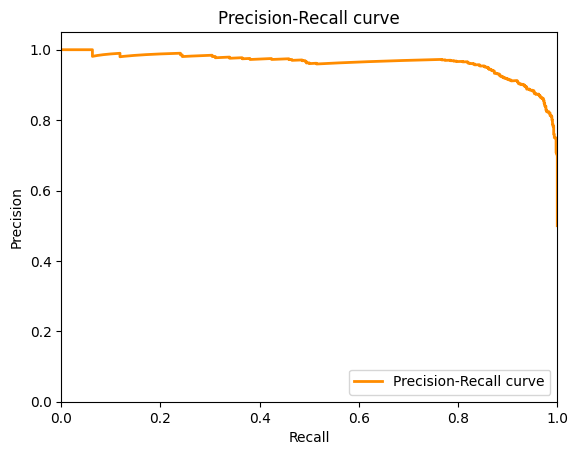

In [42]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test, svm_model.predict_proba(X_test_tfidf)[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)

# Compute precision-recall
precision, recall, thresholds = precision_recall_curve(y_test, svm_model.predict_proba(X_test_tfidf)[:,1], pos_label=1)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower right")
plt.show()